In [1578]:
import numpy as np
import os
import pandas as pd

### functions

In [1579]:
def split_covid_data(arr_path, normalize=True):
    covid_data = np.load(arr_path)
    covid_data = covid_data.astype(np.float32)
    
    if normalize: 
        data_mean = np.mean(covid_data, axis=1, keepdims=True)
        data_std = np.std(covid_data, axis=1, keepdims=True)
        covid_data = (covid_data - data_mean) / data_std
        stats_train = (data_mean[:709,:], data_std[:709,:])
        stats_val = (data_mean[709:798, :], data_std[709:798, :])
        stats_test = (data_mean[798:, :], data_std[798:,:])
        stats = (stats_train, stats_val, stats_test)
    else: 
        stats = None
    
    train_data = covid_data[:709,:]
    val_data = covid_data[709:798,:]
    test_data = covid_data[798:, :]

    # reshaping arrays:
    train_data = np.reshape(train_data, newshape=(train_data.shape[0], train_data.shape[1], 1))
    val_data = np.reshape(val_data, newshape=(val_data.shape[0], val_data.shape[1], 1))
    test_data = np.reshape(test_data, newshape=(test_data.shape[0], test_data.shape[1], 1))

    return train_data, val_data, test_data, stats

In [1580]:
def rescale_covid_data(data_sample, stats, index):
    data_mean, data_std = stats
    mean, std = data_mean[index], data_std[index]
    data_sample = std * data_sample + mean
    data_sample = data_sample.astype(np.int32)
    return data_sample

In [1581]:
covid_path = '../../data/covid_preprocess.npy'
train_data, val_data, test_data, stats = split_covid_data(covid_path)
stats_train, stats_val, stats_test = stats
train_data_unnorm, val_data_unnorm, test_data_unnorm, _ = split_covid_data(covid_path, normalize=False)

In [1582]:
sum_test_data = np.sum(test_data_unnorm, axis=1)
print(np.max(sum_test_data))
print(np.argmax(sum_test_data))

20504.0
33


In [1583]:
sum_test_data_20 = np.sum(test_data_unnorm[:,40:], axis=1)

In [1584]:
std_test_data_20 = np.std(test_data_unnorm[:,40:], axis=1)
#std_test_data_20

In [1585]:
std_test_data_20 = pd.DataFrame(std_test_data_20)
#std_test_data_20

In [1586]:
#std_test_data_20[std_test_data_20 > 10][70:]

In [1587]:
print(sum_test_data[10])
print(sum_test_data[88])
print(sum_test_data[7])
print(sum_test_data[73])

[863.]
[1466.]
[3608.]
[2878.]


In [1588]:
print(list(val_data_unnorm[67].reshape(61)))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 3.0, 3.0, 3.0, 3.0, 3.0, 8.0, 8.0, 8.0, 8.0, 8.0, 15.0, 15.0, 15.0, 15.0, 16.0, 19.0]


In [1589]:
print(list(test_data_unnorm[67].reshape(61)))

[0.0, 0.0, 0.0, 2.0, 2.0, 4.0, 2.0, 4.0, 6.0, 9.0, 13.0, 18.0, 3.0, 12.0, 2.0, 10.0, 10.0, 14.0, 12.0, 18.0, 26.0, 29.0, 22.0, 18.0, 24.0, 27.0, 28.0, 42.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 34.0, 34.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [1590]:
#indexes = [10,88,7,73] 
#indexes = [77,88,72,2]
#indexes = [33,76,73]
indexes = [72,2,7]
#indexes = [2]
N = 1

In [1591]:
smc_t_path = '../../output/covid_SMC_T/covid_smc_t_10_p'
lstm_path = '../../output/covid_rnn/covid_LSTM_64_pdrop_0.2_rnndrop_0.2'

In [1592]:
def eliminate_neg_values(arr): 
    arr[arr < 0] = 0
    return arr

In [1593]:
def get_mc_distribs(mc_samples_path, data_unnorm, stats, indexes):
    lstm_preds, mc_distribs, true_labels = [], [], []
    mc_samples = np.load(mc_samples_path)
    for index in indexes:
        true_label = data_unnorm[index, :-1].reshape(60)
        true_labels.append(true_label)
        mc_sample = mc_samples[index,:,:]
        mc_sample = rescale_covid_data(data_sample=mc_sample, stats=stats, index=index)
        mc_sample = np.transpose(mc_sample)
        lstm_pred = np.mean(mc_sample, axis=1)
        lstm_preds.append(lstm_pred)
        mc_sample = mc_sample[40:, :]
        mc_distribs.append(mc_sample)
    return true_labels, lstm_preds, mc_distribs

In [1594]:
#mc_samples_path_uni = '../../output/covid_rnn/covid_LSTM_64_pdrop_0.2_rnndrop_0.2/mc_dropout_samples_test_data.npy'
#mc_samples_path_multi = '../../output/covid_rnn/covid_LSTM_64_pdrop_0.2_rnndrop_0.2/mc_dropout_samples_test_data_multi.npy'
#true_labels, lstm_means, mc_distribs = get_mc_distribs_val_data(lstm_path, val_data_unnorm, stats_val, val_indexes)
#true_labels, lstm_means, mc_distribs = get_mc_distribs(mc_samples_path_uni, test_data_unnorm, stats_test, indexes)
#_, lstm_means_multi, mc_distribs_multi = get_mc_distribs(mc_samples_path_multi, test_data_unnorm, stats_test, indexes)

In [1595]:
mc_path_2 = '../../output/covid_rnn/covid_LSTM_64_pdrop_0.2_rnndrop_0.2/mc_dropout_samples_test_data_multi.npy'
mc_path_5 = '../../output/covid_rnn/covid_LSTM_64_pdrop_0.5_rnndrop_0.5/mc_dropout_samples_test_data_multi.npy'
true_labels, lstm_means_2, mc_distribs_2 = get_mc_distribs(mc_path_2, test_data_unnorm, stats_test, indexes)
true_labels, lstm_means_5, mc_distribs_5 = get_mc_distribs(mc_path_5, test_data_unnorm, stats_test, indexes)

In [1596]:
def get_distrib_means_unistep(smc_t_path, test_data_unnorm, indexes, stats_test):
    true_labels, distribs_10, means_10 = [], [], []
    #lstm_preds, mc_distribs = [], []
    for index in indexes: 

        mean_preds_10_p_path = os.path.join(smc_t_path, 'mean_preds_sample_{}_N_{}.npy'.format(index, N))                              
        distrib_10_p_path = os.path.join(smc_t_path, 'distrib_future_timesteps_sample_{}_N_{}.npy'.format(index, N))
        mean_preds_10 = np.load(mean_preds_10_p_path)
        distrib_10 = np.load(distrib_10_p_path)
        true_label = test_data_unnorm[index, :-1].reshape(60)

        mean_preds_rescaled_10 = rescale_covid_data(mean_preds_10, stats=stats_test, index=index)
        distrib_rescaled_10 = rescale_covid_data(distrib_10, stats=stats_test, index=index)
        distrib_rescaled_10 = eliminate_neg_values(distrib_rescaled_10)
        true_labels.append(true_label)
        means_10.append(mean_preds_rescaled_10)
        distribs_10.append(distrib_rescaled_10)
        
    return true_labels, means_10, distribs_10

In [1597]:
def get_distrib_means_unistep_2(smc_t_path, indexes, stats_test):
    distribs_10, means_10 = [], []
    for index in indexes: 

        mean_preds_10_p_path = os.path.join(smc_t_path, 'mean_preds_2_sample_{}_N_{}.npy'.format(index, N))                              
        distrib_10_p_path = os.path.join(smc_t_path, 'distrib_future_timesteps_2_sample_{}_N_{}.npy'.format(index, N))
        mean_preds_10 = np.load(mean_preds_10_p_path)
        distrib_10 = np.load(distrib_10_p_path)

        mean_preds_rescaled_10 = rescale_covid_data(mean_preds_10, stats=stats_test, index=index)
        distrib_rescaled_10 = rescale_covid_data(distrib_10, stats=stats_test, index=index)
        distrib_rescaled_10 = eliminate_neg_values(distrib_rescaled_10)
        
        means_10.append(mean_preds_rescaled_10)
        distribs_10.append(distrib_rescaled_10)

    return means_10, distribs_10

In [1598]:
def get_distrib_means_multistep(smc_t_path, indexes, stats_test, particles=False):
    distribs_10, means_10, particles_10 = [], [], []
    for index in indexes: 

        mean_preds_10_p_path = os.path.join(smc_t_path, 'mean_preds_sample_{}_N_{}_multi.npy'.format(index, N))                              
        distrib_10_p_path = os.path.join(smc_t_path, 'distrib_future_timesteps_sample_{}_N_{}_multi.npy'.format(index, N))
        mean_preds_10 = np.load(mean_preds_10_p_path)
        distrib_10 = np.load(distrib_10_p_path)
            
        mean_preds_rescaled_10 = rescale_covid_data(mean_preds_10, stats=stats_test, index=index)
        distrib_rescaled_10 = rescale_covid_data(distrib_10, stats=stats_test, index=index)
        distrib_rescaled_10 = eliminate_neg_values(distrib_rescaled_10)
        
        if particles: 
            particules_10_p_path = os.path.join(smc_t_path, 'particules_sample_{}_N_{}_multi.npy'.format(index, N))
            particule_10 = np.load(particules_10_p_path)
            particule_10 = rescale_covid_data(particule_10, stats=stats_test, index=index)
            particule_10 = eliminate_neg_values(particule_10)
            particles_10.append(particule_10)
        
        means_10.append(mean_preds_rescaled_10)
        distribs_10.append(distrib_rescaled_10)

    return means_10, distribs_10, particles_10

In [1599]:
#true_labels, means, distribs = get_distrib_means_unistep(smc_t_path=smc_t_path, 
                                                         #test_data_unnorm=test_data_unnorm, 
                                                         #indexes=indexes, 
                                                         #stats_test=stats_test)
#means, distribs = get_distrib_means_unistep_2(smc_t_path=smc_t_path, indexes=indexes, stats_test=stats_test)
means_multi, distribs_multi, particles = get_distrib_means_multistep(smc_t_path=smc_t_path, 
                                                         indexes=indexes, stats_test=stats_test)
print('distrib', distribs[0].shape)
print('means', means[0].shape)

distrib (20, 1000)
means (60,)


In [1600]:
def plot_std_particules(stds_particles):
    fig, ax = plt.subplots()
    x_20 = np.linspace(40,60,20)
    
    font = {'family': 'serif',
        'weight': 'normal',
        'size': 16}
    
    states = ['VA(1)', 'MI', 'VA(2)', 'MA']
    #states = ['VA']
    #colors = ['tab:green']
    colors = ['tab:green', 'tab:blue', 'tab:red', 'tab:orange']
    for i, (st, col) in enumerate(zip(states, colors)):
        ax.plot(x_20, stds_particles[i], 'o', linestyle='dashed', color=col, label=st)

                
    ax.set_xlabel('number of days', fontdict=font)
    ax.set_ylabel('number of deaths', fontdict=font)
    
    return fig, ax

def plot_particules(true_labels, means, particules):
    fig, ax = plt.subplots(figsize=(16,10))
    x = np.linspace(1,60,60)
    x_20 = np.linspace(40,60,20)
    
    font = {'family': 'serif',
        'weight': 'normal',
        'size': 16}
    
    states = ['VA(1)', 'MI', 'VA(2)', 'MA']
    #states = ['VA']
    #colors = ['tab:green']
    colors = ['tab:green', 'tab:blue', 'tab:red', 'tab:orange']
    for i, (st, col) in enumerate(zip(states, colors)):
        ax.plot(x, true_labels[i], '-', color='tab:grey', lw=2)
        ax.plot(x, means[i], 'o', linestyle='dashed', color=col, label='SMC-T mean preds, {}'.format(st))
        for s in range(10):
                ax.scatter(x_20, particules[i][s,:], color=col)
                
    ax.set_xlabel('number of days', fontdict=font)
    ax.set_ylabel('number of deaths', fontdict=font)
    
    return fig, ax
#fig, ax = plot_std_particules(stds_particles)

### confidence intervals computation

In [1601]:
def get_distrib_stats(distrib_rescaled):
    distrib_mean = np.mean(distrib_rescaled, axis=1)
    print(distrib_mean[0])
    distrib_std = np.std(distrib_rescaled, axis=1)
    print(distrib_std[0])
    distrib_max = np.max(distrib_rescaled, axis=1)
    distrib_min = np.min(distrib_rescaled, axis=1)
    return distrib_mean, distrib_std, distrib_max, distrib_min

In [1602]:
def pad_array(array):
    pad_distrib = np.zeros(shape=60)
    pad_distrib[40:] = array
    return pad_distrib

In [1603]:
def get_errors(distrib_mean, distrib_std, distrib_max, distrib_min):
    #lower_bound = pad_distrib_mean - 1.960 * pad_distrib_std / (1000**(1/2))
    #upper_bound = pad_distrib_mean + 1.960 * pad_distrib_std / (1000**(1/2))
    lower_bound = distrib_mean - distrib_std
    upper_bound = distrib_mean + distrib_std
    lower_bound = eliminate_neg_values(lower_bound)
    return lower_bound, upper_bound

In [1604]:
def get_confidence_interval_from_distrib(distribs):
    ints = []
    for distrib in distribs:
        mean_10, std_10, max_10, min_10 = get_distrib_stats(distrib)
        lb_min_10, lb_max_10 = get_errors(mean_10, std_10, max_10, min_10)
        int_10 = [lb_min_10, lb_max_10]
        ints.append(int_10)
    return ints

In [1605]:
ints_multi = get_confidence_interval_from_distrib(distribs_multi)
print('done')
lstm_ints_2 = get_confidence_interval_from_distrib(mc_distribs_2)
lstm_ints_5 = get_confidence_interval_from_distrib(mc_distribs_5)

53.543
17.10175871072914
156.409
20.964677889249813
98.993
10.411001440783687
done
49.126
2.4129077893694952
138.843
6.422643614587374
101.326
4.571184091676912
46.052
3.187051301752137
132.2
7.836836096282732
101.063
8.234016699035768


In [1659]:
means_multi_from_distrib = []
for distrib in distribs_multi:
    mean_distrib, _, _, _ = get_distrib_stats(distrib)
    means_multi_from_distrib.append(mean_distrib)

53.543
17.10175871072914
156.409
20.964677889249813
98.993
10.411001440783687


In [1661]:
means_multi_from_distrib[0].shape

(20,)

In [1606]:
np.mean(mc_distribs_multi[0], axis=1)

array([49.126, 52.168, 54.783, 57.391, 60.007, 62.688, 65.476, 68.405,
       71.395, 74.143, 76.995, 79.842, 82.363, 84.911, 87.326, 89.283,
       91.461, 93.595, 95.028, 96.575])

In [1607]:
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook

In [1664]:
def plot_inference_smc_t(title, true_labels, LSTM_means_2, LSTM_ints_2, LSTM_means_5, LSTM_ints_5, means_10, ints_10, distribs=None):
    fig, ax = plt.subplots(figsize=(16,10))
    x = np.linspace(1,60,60)
    x_20 = np.linspace(40,60,20)
    
    font = {'family': 'serif',
        'weight': 'normal',
        'size': 20}
    number_samples = len(means_10)
    #states = ['Unassigned - MARYLAND', 'Fairfax - VIRGINIA', 'Unassigned - NEBRASKA', 'Unassigned - NEVADA'][:number_samples]
    states = ['Unassigned - MARYLAND', 'Fairfax - VIRGINIA', 'Henrico - VIRGINIA'][:number_samples]
    colors = ['tab:green', 'tab:blue', 'tab:red', 'tab:orange'][:number_samples]
    colors_2 = ['darkgreen', 'darkblue', 'darkred', 'darkorange'][:number_samples]
    for i, (st, col, col2) in enumerate(zip(states, colors, colors_2)):
        ax.plot(x, true_labels[i], '-', color='k', lw=2)
        if means_10 is not None: 
            ax.plot(x, means_10[i], color=col, lw=2, label='SMC-T, {}'.format(st))
            ax.fill_between(x_20, ints_10[i][0], ints_10[i][1], alpha=0.3, facecolor=col, edgecolor=col)
            if distribs is not None:
                for s in range(1000):
                    ax.scatter(x_20, distribs[i][:,s], color=col)
        if LSTM_means_2 is not None: 
            ax.plot(x, LSTM_means_2[i], 'x', linestyle='dotted', color=col2, label='LSTM - dropout=0.2, {}'.format(st))
            ax.fill_between(x_20, LSTM_ints_2[i][0], LSTM_ints_2[i][1], alpha=0.3, facecolor='tab:grey', edgecolor='k', hatch=r"//")
        if LSTM_means_5 is not None: 
            ax.plot(x, LSTM_means_5[i], 'o', linestyle='dotted', color=col2, label='LSTM - dropout=0.5, {}'.format(st))
            ax.fill_between(x_20, LSTM_ints_5[i][0], LSTM_ints_5[i][1], alpha=0.1, edgecolor='k', facecolor='grey', hatch=r".")
    
    ax.set_xlabel('number of days', fontdict=font)
    ax.set_ylabel('number of deaths', fontdict=font)
    #ax.set_title(title, fontdict=font)
    ax.legend(fontsize=20, markerscale=2, frameon=False)
    ax.grid(lw=1, alpha=0.2)
    ax.tick_params(labelsize=20)
    
    return fig, ax

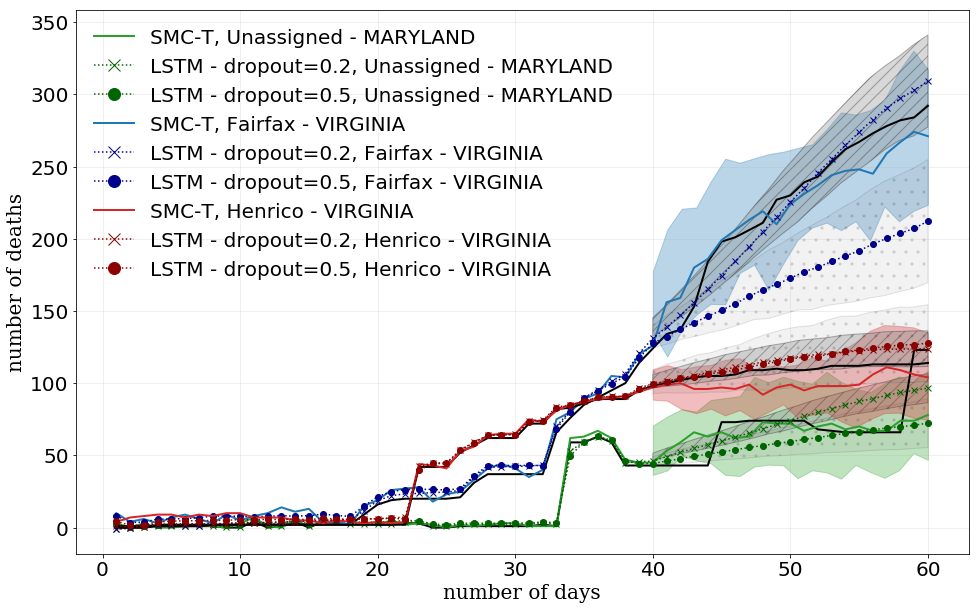

In [1665]:
title = "predicted versus true covid deaths with error bars from day 40 - 4 cities"
#fig, ax = plot_inference_smc_t(title, true_labels, None, None, means, ints, None)
fig, ax = plot_inference_smc_t(title, true_labels, lstm_means_2, lstm_ints_2, lstm_means_5, lstm_ints_5, means_multi, ints_multi, None)
#fig, ax = plot_inference_smc_t(title, val_labels, lstm_means, ints_lstm, None, None, None)

In [1655]:
save_path = 'smc_t_multistep_samples_{}_{}_{}_with_mc_dropout_02_05'.format(indexes[0], indexes[1], indexes[2])
fig_path = os.path.join(smc_t_path, save_path)
fig.savefig(fig_path)

### adding mc dropout

In [538]:
def plot_mc_dropout(title, x, true_labels, lstm_means, ints_lstm):
    fig, ax = plt.subplots(figsize=(16,10))
    font = {'family': 'serif',
        'weight': 'normal',
        'size': 16}
    #states = ['VA(1)', 'MI', 'VA(2)', 'MA']
    states = ['VA(1)']
    colors = ['tab:green']
    for i, (st, col) in enumerate(zip(states, colors)):
        ax.plot(x, true_labels[i], '-', color='tab:grey', lw=2)
        ax.plot(x, lstm_means[i], 'x', linestyle='dotted', color=col, label='lstm mean preds, {}'.format(st))
        ax.fill_between(x, ints_lstm[i][0], ints_lstm[i][1], alpha=0.2, color='tab:grey', hatch=r"//")
    
    ax.set_xlabel('number of days', fontdict=font)
    ax.set_ylabel('number of deaths', fontdict=font)
    ax.set_title(title, fontdict=font)
    ax.legend(fontsize=14)
    return fig, ax

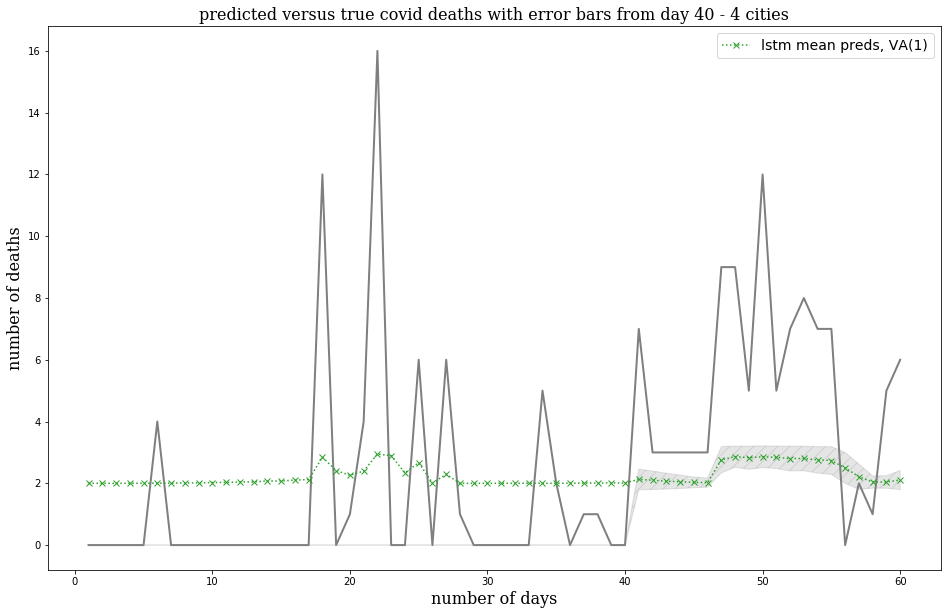

In [540]:
fig, ax = plot_mc_dropout(title, x, true_labels, lstm_preds, ints_lstm)

In [342]:
fig_path = os.path.join(lstm_out_path_1, 'lstm_preds_sample_{}'.format(index))
fig.savefig(fig_path)

NameError: name 'lstm_out_path_1' is not defined